# `grib_to_netcdf` Processing of Continental HRDPS with `pywgrib2_xr`

Exploration of doing the processing of the SalishSeaNowcast `grib_to_netcdf` worker
to generate NEMO atmospheric forcing files for SalishSeaCast from the
ECCC MSC 2.5 km rotated lat-lon continental grid HRDPS GRIB2 files using the `pywgrib2_xr` package.

`pywgrib2_xr`:
* code: https://github.com/yt87/pywgrib2_xr
* docs: https://yt87.github.io/pywgrib2_xr/index.html

`conda` environment description for this notebook: `analysis-doug/notebooks/continental-HRDPS/environment-pywgrib2_xr.yaml`

**Notes:**
* the `pywgrib2_xr` conda package is published on the `yt87` channel, not on `conda-forge`
* the published package supports only Python 3.7, 3.8, and 3.9
* it has an important dependency limits that is *not* specified in the published package:
* there is a runtime `ImportError`:
  ```python-traceback
      Traceback (most recent call last):
        File "/home/doug/conda_envs/pywgrib2-xarray-2022.11/bin/pywgrib2", line 33, in <module>
          sys.exit(load_entry_point('pywgrib2-xr==0.2.3', 'console_scripts', 'pywgrib2')())
        File "/home/doug/conda_envs/pywgrib2-xarray-2022.11/bin/pywgrib2", line 25, in importlib_load_entry_point
          return next(matches).load()
        File "/home/doug/conda_envs/pywgrib2-xarray-2022.11/lib/python3.9/importlib/metadata.py", line 86, in load
          module = import_module(match.group('module'))
        File "/home/doug/conda_envs/pywgrib2-xarray-2022.11/lib/python3.9/importlib/__init__.py", line 127, in import_module
          return _bootstrap._gcd_import(name[level:], package, level)
        File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
        File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
        File "<frozen importlib._bootstrap>", line 972, in _find_and_load_unlocked
        File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
        File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
        File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
        File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
        File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
        File "<frozen importlib._bootstrap_external>", line 850, in exec_module
        File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
        File "/home/doug/conda_envs/pywgrib2-xarray-2022.11/lib/python3.9/site-packages/pywgrib2_xr/__init__.py", line 30, in <module>
          from .accessor import Wgrib2DatasetAccessor
        File "/home/doug/conda_envs/pywgrib2-xarray-2022.11/lib/python3.9/site-packages/pywgrib2_xr/accessor.py", line 9, in <module>
          from xarray.core.pycompat import dask_array_type
      ImportError: cannot import name 'dask_array_type' from 'xarray.core.pycompat' (/home/doug/conda_envs/pywgrib2-xarray-2022.11/lib/python3.9/site-packages/xarray/core/pycompat.py)
  ```
  with `xarray=2023.02`
  * experiments found that the most recent `xarray` version that `pywgrib2_xr` works with is `xarray=2022.10`

This notebook assumes that the MOAD `/results/` file system is mounted.

## Play with the Low Level `wgrib2` Interface

`pywgrib2_xr.wgrib()` is a wrapper for the
[wgrib2](https://www.cpc.ncep.noaa.gov/products/wesley/wgrib2/long_cmd_list.html)
command-line tool

In [19]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pywgrib2_xr
import xarray

In [2]:
west_files = Path("/results/forcing/atmospheric/GEM2.5/GRIB/20230215/00/001/")
conti_files = Path("/results/forcing/atmospheric/continental2.5/GRIB/20230215/00/001/")

west_u_file = west_files / "CMC_hrdps_west_UGRD_TGL_10_ps2.5km_2023021500_P001-00.grib2"

conti_u_file = conti_files / "20230215T00Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT001H.grib2"
conti_v_file = conti_files / "20230215T00Z_MSC_HRDPS_VGRD_AGL-10m_RLatLon0.0225_PT001H.grib2"

In [4]:
pywgrib2_xr.wgrib(west_u_file)
pywgrib2_xr.free_files(os.fspath(west_u_file))

1:0:d=2023021500:UGRD:10 m above ground:60 min fcst:


**Note:** `pywgrib2_xr.wgrib()` calls aren't repeatable unless the file is freed with `free_files()`.

I feel a context manager coming on...

### Get grid descriptions:

In [5]:
args = "-d 1 -grid"
pywgrib2_xr.wgrib(*args.split(), west_u_file)
pywgrib2_xr.free_files(os.fspath(west_u_file))

1:0:grid_template=20:winds(grid):
	polar stereographic grid: (685 x 485) input WE:SN output WE:SN res 8
	North pole lat1 44.689624 lon1 230.093688 latD 60.000000 lonV 247.000000 dx 2500.000000 m dy 2500.000000 m


In [6]:
args = "-d 1 -grid"
pywgrib2_xr.wgrib(*args.split(), conti_u_file)
pywgrib2_xr.free_files(os.fspath(conti_u_file))

1:0:grid_template=1:winds(grid):
	rotated lat-lon grid:(2540 x 1290) units 1e-06 input WE:SN output WE:SN res 56
	lat -12.302501 to 16.700001 by 0.022500
	lon 345.178780 to 42.306283 by 0.022500 #points=3276600
	south pole lat=-36.088520 lon=245.305142 angle of rot=0.000000


For the rotated lat-lon grid, the grid description string that is required to do remapping
(e.g. rotation of winds) has the format:

        rot-ll:sp_lon:sp_lat:sp_rot lon0:nlon:dlon lat0:nlat:dlat

where:

        sp_lon = longitude of the South pole (for rotation)
        sp_lat = latitude of the South pole (for rotation)
        sp_rot = angle of rotation (degrees)
 
        lat0, lon0 = degrees of lat/lon for 1st grid point 
        nlat = number of longitudes
        nlon = number of latitudes
        dlon = grid cell size in degrees of longitude
        dlat = grid cell size in degrees of latitude

See: https://www.cpc.ncep.noaa.gov/products/wesley/wgrib2/new_grid.html

There does not appear to be a code way to substitute in values from the grid description above.
Doing it by inspection gives:

In [7]:
conti_grid_desc = (
    "rot-ll:245.305142:-36.088520:0.000000 345.178780:2540:0.022500 -12.302501:1290:0.022500"
)

### `grib_to_netcdf._rotate_grib_wind()` Processing

2 steps:
1) create a GRIB2 file containing the UGRD and VGRD variables
2) remap that file from the model grid to an u-goes-east, v-goes-north grid

In [8]:
in_files = (conti_u_file, conti_v_file)
out_file = Path("/tmp", "uv_py.grib")
out_file.unlink(missing_ok=True)
args = f"-append -grib {out_file}"

for f in in_files:
    pywgrib2_xr.wgrib(f, *args.split())
    pywgrib2_xr.free_files(os.fspath(f))

!ls -lh /tmp/*.grib

1:0:d=2023021500:UGRD:10 m above ground:60 min fcst:
1:0:d=2023021500:VGRD:10 m above ground:60 min fcst:
-rw-rw-r-- 1 doug doug 3.6M Mar  6 10:32 /tmp/uv_py.grib


In [9]:
in_file = out_file
out_file = Path( "/tmp", "uvrot_py.grib")
out_file.unlink(missing_ok=True)
args = f"-new_grid_winds earth -new_grid {conti_grid_desc}"

pywgrib2_xr.wgrib(in_file, *args.split(), out_file)
pywgrib2_xr.free_files(os.fspath(in_file), os.fspath(out_file))

!ls -lh /tmp/*.grib

1:0:d=2023021500:UGRD:10 m above ground:60 min fcst:
2:1827917:d=2023021500:VGRD:10 m above ground:60 min fcst:
-rw-rw-r-- 1 doug doug 3.6M Mar  6 10:32 /tmp/uv_py.grib
-rw-rw-r-- 1 doug doug 9.4M Mar  6 10:32 /tmp/uvrot_py.grib


Susan confirmed that `uvrot_py.grib` compares well with velocities from west domain in
https://nbviewer.org/github/SalishSeaCast/tools/blob/main/I_ForcingFiles/Atmos/CheckRotation.ipynb

#### Repeat Using `xarray` Interface

First, create a template for the dataset.
It holds parameters common to all messages within the dataset:
data origin (from Section 1), geolocation (Section 3), variable names,
optional forecast times, and vertical dimensions. 

See: https://yt87.github.io/pywgrib2_xr/template.html

**Note:** We don't need variable selector predicates (`lambda`s in the linked docs)
because HRDPS stores one variable per file.

In [10]:
in_files = (conti_u_file, conti_v_file)
in_file_strs = [os.fspath(f) for f in in_files]
tmpl = pywgrib2_xr.make_template(in_file_strs)

tmpl

Coordinates:
{'x': _Variable(dims=('x',), data=array([345.17878   , 345.0594919 , 344.94020379, ...,  42.54485921,
        42.4255711 ,  42.306283  ]), attrs={'units': 'degree', 'standard_name': 'projection_x_coordinate', 'axis': 'X'}), 'y': _Variable(dims=('y',), data=array([-12.302501, -12.280001, -12.257501, ...,  16.655001,  16.677501,
        16.700001]), attrs={'units': 'degree', 'standard_name': 'projection_y_coordinate', 'axis': 'X'}), 'longitude': _Variable(dims=('y', 'x'), data=array([[226.37048048, 226.39797748, 226.4254798 , ..., 292.99444258,
        293.01401325, 293.0335779 ],
       [226.36263786, 226.39014516, 226.41765779, ..., 293.00993369,
        293.02950729, 293.04907488],
       [226.35479031, 226.38230792, 226.40983087, ..., 293.02542977,
        293.04500631, 293.06457683],
       ...,
       [207.32807086, 207.37435309, 207.42067378, ..., 319.19941341,
        319.21824118, 319.2370592 ],
       [207.29872511, 207.34502451, 207.39136245, ..., 319.2266097 ,
  

Then, load the GRIB2 files into an `xarray` dataset.

See: https://yt87.github.io/pywgrib2_xr/reading.html

In [11]:
ds = pywgrib2_xr.open_dataset(in_file_strs, tmpl)

ds

<xarray.Dataset>
Dimensions:                     (y: 1290, x: 2540)
Coordinates:
  * x                           (x) float64 345.2 345.1 344.9 ... 42.43 42.31
  * y                           (y) float64 -12.3 -12.28 -12.26 ... 16.68 16.7
    longitude                   (y, x) float64 ...
    latitude                    (y, x) float64 ...
    time1                       timedelta64[ns] ...
    reftime                     datetime64[ns] ...
    rotated_latitude_longitude  int64 ...
Data variables:
    UGRD.10_m_above_ground      (y, x) float32 ...
    VGRD.10_m_above_ground      (y, x) float32 ...
Attributes:
    Projection:             rotated_latitude_longitude
    Originating centre:     54 - Canadian Meteorological Service - Montreal (...
    Originating subcentre:  0
    History:                Created by pywgrib2_xr-0.2.3

Finally, remap the grid to put wind components on the north-east oriented grid.

In [12]:
ds_rot = ds.wgrib2.grid(
    pywgrib2_xr.grid_fromstring(conti_grid_desc, winds="earth"),
    iptype="bilinear",
)

ds_rot

<xarray.Dataset>
Dimensions:                     (y: 1290, x: 2540)
Coordinates:
    rotated_latitude_longitude  int64 0
  * x                           (x) float64 345.2 345.1 344.9 ... 42.43 42.31
  * y                           (y) float64 -12.3 -12.28 -12.26 ... 16.68 16.7
    longitude                   (y, x) float64 226.4 226.4 226.4 ... 319.3 319.3
    latitude                    (y, x) float64 39.63 39.63 39.64 ... 47.89 47.88
    time1                       timedelta64[ns] 01:00:00
    reftime                     datetime64[ns] 2023-02-15
Data variables:
    UGRD.10_m_above_ground      (y, x) float64 1.669 1.643 1.557 ... 11.6 11.57
    VGRD.10_m_above_ground      (y, x) float64 -6.514 -6.557 ... 4.931 4.842
Attributes:
    Projection:             rotated_latitude_longitude
    Originating centre:     54 - Canadian Meteorological Service - Montreal (...
    Originating subcentre:  0
    History:                Created by pywgrib2_xr-0.2.3

#### Look at the dataset

Indices of continental grid region of interest for SalishSeaCast

In [13]:
ymin, ymax = 230, 460
xmin, xmax = 300, 490
ys, xs = slice(ymin, ymax), slice(xmin, xmax)

Colour mesh of u wind component

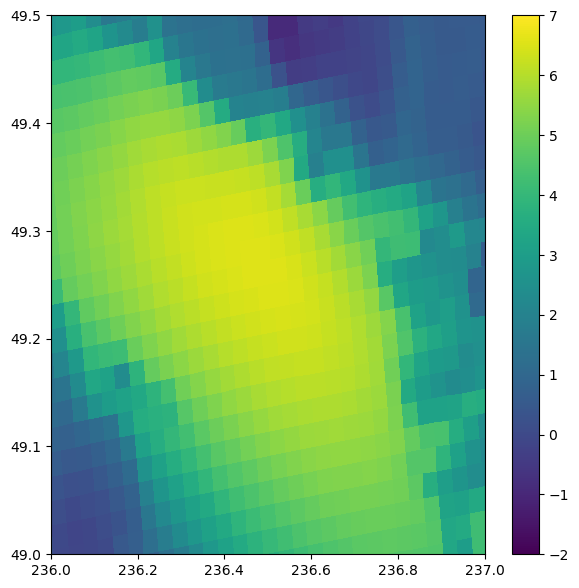

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
colours = ax.pcolormesh(
    ds_rot.longitude.isel(y=ys, x=xs),
    ds_rot.latitude.isel(y=ys, x=xs),
    ds_rot["UGRD.10_m_above_ground"].isel(y=ys, x=xs),
    vmax=7, vmin=-2
)
fig.colorbar(colours)
ax.set_ylim(49, 49.5)
ax.set_xlim(236, 237);

Quiver plot of wind vectors

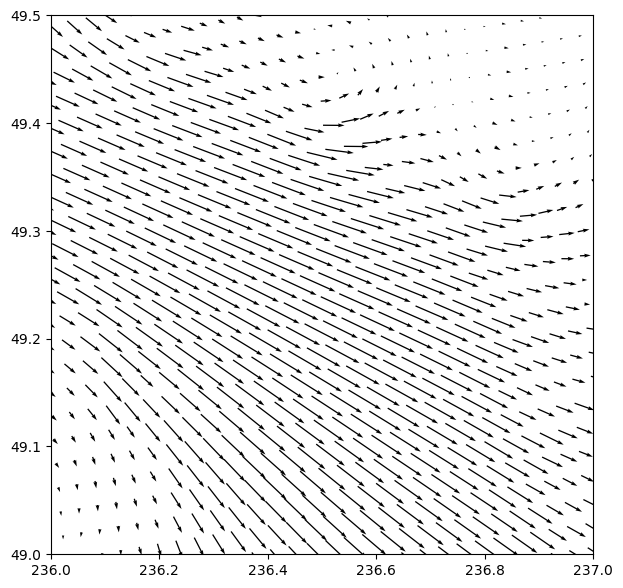

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.quiver(
    ds.longitude.isel(y=ys, x=xs),
    ds_rot.latitude.isel(y=ys, x=xs),
    ds_rot["UGRD.10_m_above_ground"].isel(y=ys, x=xs),
    ds_rot["VGRD.10_m_above_ground"].isel(y=ys, x=xs),
    scale=100,
)
ax.set_ylim(49, 49.5)
ax.set_xlim(236, 237);

In [26]:
ds_rot.to_netcdf("~/Desktop/uv_rot_py.nc")

In [15]:
ls /results/forcing/atmospheric/continental2.5/nemo_forcing

hrdps_y2023m01d19.nc             oper_allvar_small_y2023m01d19.grib
oper_000_small_y2023m01d19.grib


In [22]:
all_vars_grib = "/results/forcing/atmospheric/continental2.5/nemo_forcing/oper_allvar_small_y2023m01d19.grib"
all_vars_str = os.fspath(all_vars_grib)
tmpl = pywgrib2_xr.make_template(all_vars_str)

tmpl

Coordinates:
{'x': _Variable(dims=('x',), data=array([345.17878   , 345.05949189, 344.94020379, ...,  42.54485621,
        42.42556811,  42.30628   ]), attrs={'units': 'degree', 'standard_name': 'projection_x_coordinate', 'axis': 'X'}), 'y': _Variable(dims=('y',), data=array([-12.302501, -12.280001, -12.257501, ...,  16.654999,  16.677499,
        16.699999]), attrs={'units': 'degree', 'standard_name': 'projection_y_coordinate', 'axis': 'X'}), 'longitude': _Variable(dims=('y', 'x'), data=array([[226.37048048, 226.39797748, 226.4254798 , ..., 292.99443997,
        293.01401064, 293.0335753 ],
       [226.36263786, 226.39014516, 226.41765779, ..., 293.00993108,
        293.02950468, 293.04907227],
       [226.35479031, 226.38230792, 226.40983087, ..., 293.02542716,
        293.0450037 , 293.06457422],
       ...,
       [207.32807347, 207.37435569, 207.42067638, ..., 319.19940849,
        319.21823626, 319.23705428],
       [207.29872772, 207.34502712, 207.39136505, ..., 319.22660478,
  

In [23]:
ds = pywgrib2_xr.open_dataset(all_vars_str, tmpl)

ds

<xarray.Dataset>
Dimensions:                     (time14: 12, y: 1290, x: 2540, time8: 1,
                                 time7: 1, time4: 1, time11: 1, time5: 1,
                                 time10: 1, time9: 1, time2: 1, time1: 1,
                                 time12: 1, time3: 1, time13: 1, time6: 1)
Coordinates: (12/20)
  * x                           (x) float64 345.2 345.1 344.9 ... 42.43 42.31
  * y                           (y) float64 -12.3 -12.28 -12.26 ... 16.68 16.7
    longitude                   (y, x) float64 ...
    latitude                    (y, x) float64 ...
  * time14                      (time14) timedelta64[ns] 01:00:00 ... 12:00:00
  * time8                       (time8) timedelta64[ns] 06:00:00
    ...                          ...
  * time12                      (time12) timedelta64[ns] 09:00:00
  * time3                       (time3) timedelta64[ns] 10:00:00
  * time13                      (time13) timedelta64[ns] 11:00:00
  * time6                       (time6) timedelta64[ns] 12:00:00
    reftime                     datetime64[ns] ...
    rotated_latitude_longitude  int64 ...
Data variables: (12/44)
    UGRD.10_m_above_ground      (time14, y, x) float32 ...
    VGRD.10_m_above_ground      (time14, y, x) float32 ...
    DSWRF.surface.6_hour_acc    (time8, y, x) float32 ...
    DLWRF.surface.6_hour_acc    (time8, y, x) float32 ...
    LHTFL.surface               (time7, y, x) float32 ...
    TMP.2_m_above_ground        (time14, y, x) float32 ...
    ...                          ...
    DSWRF.surface.11_hour_acc   (time13, y, x) float32 ...
    DLWRF.surface.11_hour_acc   (time13, y, x) float32 ...
    APCP.surface.11_hour_acc    (time13, y, x) float32 ...
    DSWRF.surface.12_hour_acc   (time6, y, x) float32 ...
    DLWRF.surface.12_hour_acc   (time6, y, x) float32 ...
    APCP.surface.12_hour_acc    (time6, y, x) float32 ...
Attributes:
    Projection:             rotated_latitude_longitude
    Originating centre:     54 - Canadian Meteorological Service - Montreal (...
    Originating subcentre:  0
    History:                Created by pywgrib2_xr-0.2.3